# `Notebook Contents`
- Importing The Dependencies
- Required Functions
- Haarcascade Face Detector
- VGGFace Network
- Testing Stage

### Importing The Dependencies

In [1]:
# Matplotlib
import matplotlib.pyplot as plt

# Open CV
import cv2

# Operating System
import os

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Numpy
import numpy as np

### Required Functions

In [2]:
# Imshow function
def imshow(img,title = 'Face',size = 6):
    # Get the image height and width
    h,w = img.shape[:2]
    
    # Aspect ratio
    asp_ratio = h / w
    
    # Set the figure size
    plt.figure(figsize=(size * asp_ratio,size))
    
    # Show the image
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title(title.title())
    plt.show()

# Preprocess func
def preprocess(path):
    # Loading the image
    img = load_img(path,target_size = (224,224))
    
    # Preprocess the image
    img = img_to_array(img)
    img = np.expand_dims(img,axis = 0)
    img = preprocess_input(img)
    
    # Result
    return img

# The cosine similarity func
def cosine_similarity(src_rep,test_rep):
    # The numerator
    a = np.matmul(np.transpose(src_rep),test_rep)
    
    # The denominator
    b = np.sum(np.multiply(src_rep,src_rep))
    c = np.sum(np.multiply(test_rep,test_rep))
    
    # The result
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

### Haarcascade Face Detector

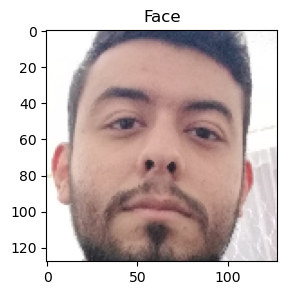

In [3]:
# Loading the model
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Making a directory
os.makedirs('ExtractedFaces')

# Path of the original images
path = 'Images'

# Path of the extracted faces
ex_path = 'ExtractedFaces'
# Get the extracted faces
for file in os.listdir(path):
    img = cv2.imread(os.path.join(path,file))
    haar_res = face_detector.detectMultiScale(img,1.3,3)
    for (x,y,w,h) in haar_res:
        face = img[y:y + h,x:x + w]
        roi = cv2.resize(face,(128,128),interpolation = cv2.INTER_CUBIC)
    
    # Save the result
    cv2.imwrite(os.path.join(ex_path,'face_'+file),roi)
    
    # Show the extracted image
    imshow(roi,size = 3)

### VGGFace Network

In [4]:
# Building the network architecture

# Sequential model
model = Sequential()

# Block1
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block2
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block3
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block4
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block5
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block6
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Loading the weights
model.load_weights('vgg_face_weights.h5')

# The model
model = Model(inputs = model.layers[0].input,outputs = model.layers[-2].output)

# The model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Input  [(None, 224, 224, 3)]    0         
 Layer)                                                          
                                                                 
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                             

### Testing Stage

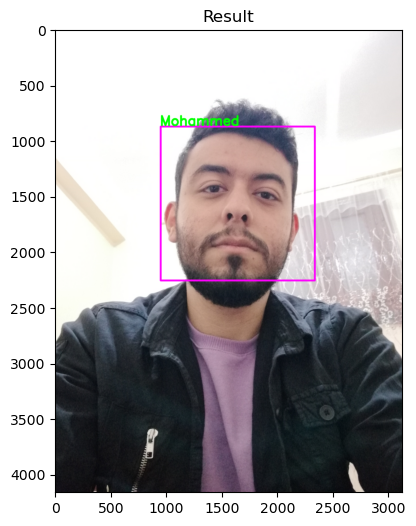

In [50]:
# Get the extracted faces pred

# People dictionary 
people = dict()

# Iterate over the extracted faces
for face in os.listdir(ex_path):
    name,extension = face.split('.')
    people[name[5:]] = model.predict(preprocess(os.path.join(ex_path,face)),verbose = 0)[0,:]

# Get the face of an image
img = cv2.imread('Mohammed.jpg')
detected_face = face_detector.detectMultiScale(img,1.3,3)

# Iterate over the face info
for (x,y,w,h) in detected_face:
    # Create rect
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),15)
    
    # Crop the face
    croped_face = img[int(y):int(y + h),int(x):int(x + w)]
    
    # Preprocess the croped face
    img_res = cv2.resize(croped_face,(224,224))
    img_res = img_to_array(img_res)
    img_res = np.expand_dims(img_res,axis = 0)
    img_res /= 255
    
    # The test representation
    test_rep = model.predict(img_res,verbose = 0)[0,:]
    
    # Counter
    cnt = 0
    
    for face_name in people:
        # The source representation
        src_rep = people[face_name]
        
        # Get the cosine similarity score
        score = cosine_similarity(src_rep,test_rep)
        
        # Check with threshold
        if score < 0.35:
            cv2.putText(img,face_name.title(),(int(x-5),int(y-12)),cv2.FONT_HERSHEY_SIMPLEX,4,(0,255,0),15)
            cnt += 1
            break
    
    # Check the counter
    if cnt == 0:
        cv2.putText(img,'Unknown',(int(x - 5),int(y - 12)),cv2.FONT_HERSHEY_SIMPLEX,4,(0,200,200),15)

# Show the results
imshow(img,'Result')